In [244]:
import torch
import torch.nn as nn
import shutil
from collections import Counter
import re
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

In [245]:
# import kagglehub
# path = kagglehub.dataset_download("adityajn105/flickr8k")
# print("Path to dataset files:", path)

In [246]:
# shutil.move(path , "./Dataset")

In [247]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold=freq_threshold
        self.itos={0:"[PAD]", 1:"[START]", 2:"[END]", 3:"[UNK]"}
        self.stoi={v:k for k,v in self.itos.items()}

    def tokenizer(self,text):
        return re.findall(r'\w+', text.lower())
        
    def build_vocabulary(self,texts):
        word_freq=Counter()

        for text in texts:
            tokens=self.tokenizer(text)
            word_freq.update(tokens)

        for word, freq in word_freq.items():
            if freq >= self.freq_threshold:
                idx=len(self.itos)
                self.itos[idx]=word
                self.stoi[word]=idx
    
    def encoder(self,text):
        tokenized_text=self.tokenizer(text)
        return [
             self.stoi.get(token, self.stoi["[UNK]"])
            for token in tokenized_text
        ]



In [248]:
test_vocab=Vocabulary(freq_threshold=1)
sample_texts=[
    "A dog is playing with a ball.",
    "A cat is sitting on the sofa.",
    "The sun is shining brightly."
]
test_vocab.build_vocabulary(sample_texts)
print(test_vocab.stoi)

{'[PAD]': 0, '[START]': 1, '[END]': 2, '[UNK]': 3, 'a': 4, 'dog': 5, 'is': 6, 'playing': 7, 'with': 8, 'ball': 9, 'cat': 10, 'sitting': 11, 'on': 12, 'the': 13, 'sofa': 14, 'sun': 15, 'shining': 16, 'brightly': 17}


In [249]:
print(test_vocab.encoder("A dog is playing in the park."))

[4, 5, 6, 7, 3, 13, 3]


In [250]:
df=pd.read_csv('./Dataset/captions.txt')
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [251]:
captions=[]
for caption in df['caption']:
    captions.append(caption)

vocab=Vocabulary(freq_threshold=3)
vocab.build_vocabulary(captions)

In [252]:
class ImageCaptionDataset(Dataset):
    def __init__(self, img_folder, caption_file_path, transform, vocabulary):
        self.img_folder=img_folder
        self.caption_file_path=caption_file_path
        self.transform=transform
        self.vocabulary=vocabulary

        self.imgs=[]
        self.captions=[]

        df=pd.read_csv(self.caption_file_path)

        for _,row in df.iterrows():
            self.imgs.append(row['image'])
            self.captions.append(row['caption'])
        
    def __len__(self):
        return len(self.imgs)   
        
    def __getitem__(self,idx):
            caption=self.captions[idx]
            image_id=self.imgs[idx]

            image_path=os.path.join(self.img_folder,image_id)
            image=Image.open(image_path).convert("RGB")

            if self.transform is not None:
                image=self.transform(image)
            
            encoded_caption=[self.vocabulary.stoi["[START]"]]+self.vocabulary.encoder(caption)+[self.vocabulary.stoi["[END]"]]
            return image, torch.tensor(encoded_caption)


In [253]:
IMAGE_PATH='./Dataset/Images'
CAPTION_FILE_PATH='./Dataset/captions.txt'

In [254]:
transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [255]:
dataset=ImageCaptionDataset(
    img_folder=IMAGE_PATH,
    caption_file_path=CAPTION_FILE_PATH,
    transform=transform,
    vocabulary=vocab
)

In [256]:
len(dataset)

40455

In [257]:
dataset[0][0].shape

torch.Size([3, 224, 224])

In [258]:
train_length=int(0.8*len(dataset))
test_length=len(dataset)-train_length
train_dataset, test_dataset=random_split(dataset, [train_length, test_length])

In [259]:
def collate_fn(batch):
    images=[]
    captions=[]

    for img, caption in batch:
        images.append(img)
        captions.append(caption)
    
    images=torch.stack(images, dim=0)

    lengths=[len(cap) for cap in captions]
    padded_captions=nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=vocab.stoi["[PAD]"])

    return images, padded_captions, lengths

In [260]:
train_loader=DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader=DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)

In [261]:
print(len(train_loader))
print(len(test_loader))

1012
253


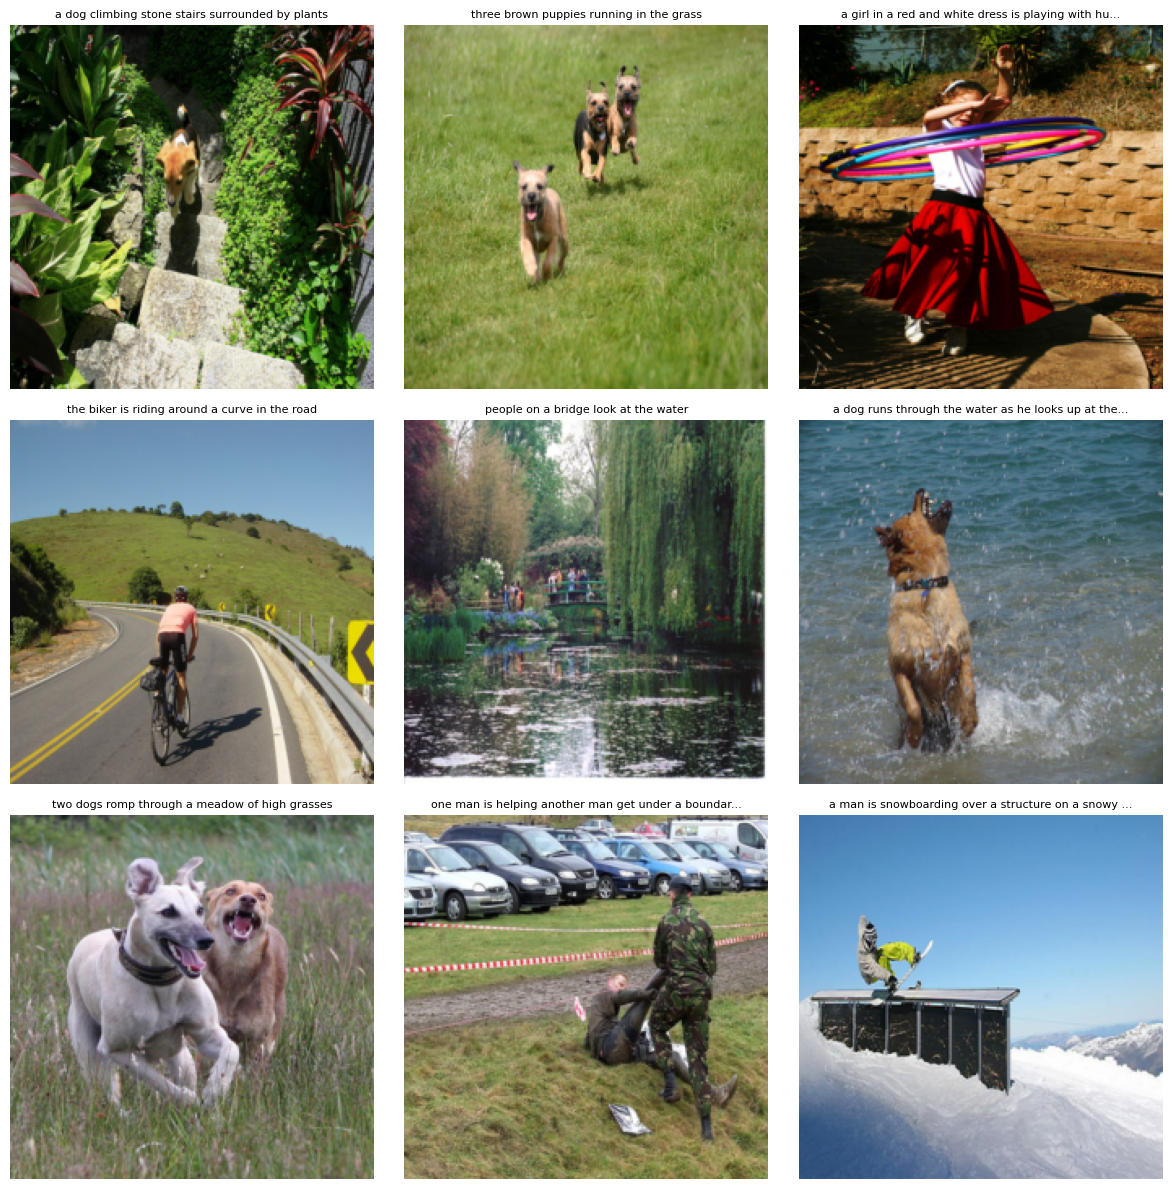

In [262]:
# Plot first 9 images from the training dataset
plt.figure(figsize=(12, 12))
for i in range(9):
    idx = train_dataset.indices[i]  
    image, caption_tensor = dataset[idx]
    
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.permute(1, 2, 0))
    
    # Decode caption back to text
    caption_indices = caption_tensor.tolist()
    caption_text = ' '.join([vocab.itos.get(idx, '[UNK]') for idx in caption_indices 
                             if idx not in [0, 1, 2]])  # Skip PAD, START, END tokens
    plt.title(caption_text[:50] + '...' if len(caption_text) > 50 else caption_text, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [263]:
class AlexNetEncoder(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.conv_layers=nn.Sequential(
            #conv1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            #conv2
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            #conv3
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(),

            #conv4
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),

            #conv5
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.fc=nn.Sequential(
            nn.Linear(in_features=256*6*6, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=emb_dim)
        )

    def forward(self,x):
        x=self.conv_layers(x)
        x=x.flatten(start_dim=1)
        x=self.fc(x)
        return x


In [264]:
class LSTMDecoder(nn.Module):
    def __init__(self,emb_dim, hidden_dim, vocab_size, num_layers=1):
        super().__init__()
        self.embedding=nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_dim)
        self.lstm=nn.LSTM(input_size=emb_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc=nn.Linear(in_features=hidden_dim, out_features=vocab_size)

    def forward(self, features, captions):
        embeddings = self.embedding(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1) 
        
        hiddens, _ = self.lstm(embeddings)
        outputs = self.fc(hiddens)
        return outputs

In [265]:
class ImageCaptionGenerator(nn.Module):
    def __init__(self,encoder,decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [266]:
EMBEDDING_DIMENSION=4096
HIDDEN_DIMENSION=512
VOCAB_SIZE=len(vocab.itos)
LEARNING_RATE=3e-4
EPOCHS=20

In [267]:
alexnet_encoder=AlexNetEncoder(emb_dim=EMBEDDING_DIMENSION)
lstm_decoder=LSTMDecoder(
    emb_dim=EMBEDDING_DIMENSION,
    hidden_dim=HIDDEN_DIMENSION,
    vocab_size=VOCAB_SIZE
)

model=ImageCaptionGenerator(
    encoder=alexnet_encoder,
    decoder=lstm_decoder
)

parameters= list(model.parameters())
print(f"Number of trainable parameters: {sum(p.numel() for p in parameters if p.requires_grad)}")

Number of trainable parameters: 85259058


In [268]:
optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion=nn.CrossEntropyLoss(ignore_index=vocab.stoi["[PAD]"])

In [269]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [270]:
model=model.to(device)

In [271]:
for epoch in range(EPOCHS):
    model.train()
    total_loss=0

    for idx, (images, captions, _) in enumerate(train_loader):
        images=images.to(device)
        captions=captions.to(device)
        optimizer.zero_grad()
        
        outputs=model(images, captions[:,:-1])  # (batch, seq_len+1, vocab_size)
        outputs=outputs[:, 1:, :]               # Remove first output (from image feature)
        
        targets=captions[:,1:]                  # (batch, seq_len)
        
        loss=criterion(outputs.reshape(-1, outputs.shape[2]), targets.reshape(-1))
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss/len(train_loader):.4f}")

Epoch [1/20], Loss: 3.7699
Epoch [2/20], Loss: 3.1281
Epoch [2/20], Loss: 3.1281


KeyboardInterrupt: 

In [ ]:
def generate_caption(model, image, vocab, device, max_len=30):
    model.eval()
    with torch.no_grad():
        feature = model.encoder(image.unsqueeze(0))  # (1, emb_dim)
        
        caption = [vocab.stoi["[START]"]]
        
        for _ in range(max_len):
            cap_tensor = torch.tensor(caption).unsqueeze(0).to(device)  
            output = model.decoder(feature, cap_tensor)  # (1, seq_len+1, vocab_size)
         
            next_word = output[:, -1, :].argmax(dim=1).item()
            caption.append(next_word)
            
            if next_word == vocab.stoi["[END]"]:
                break
    
    result_caption = []
    for idx in caption[1:]:  
        if idx == vocab.stoi["[END]"]:
            break
        result_caption.append(vocab.itos.get(idx, '[UNK]'))
    
    return " ".join(result_caption)  

Actual Caption: a dirty tan dog rolling in the dirt and looking right at the camera
Generated Caption: None


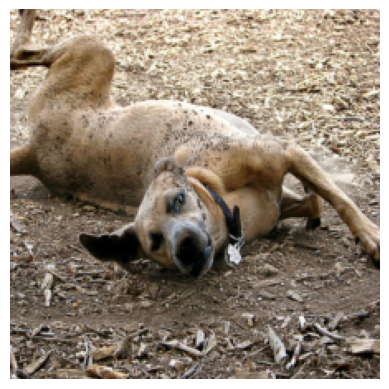

In [286]:
sample_image = test_dataset[0][0].to(device)
actual_caption = test_dataset[0][1]
caption_text = ' '.join([vocab.itos.get(idx, '[UNK]') for idx in actual_caption.tolist() 
                             if idx not in [0, 1, 2]])  # Skip PAD, START, END tokens

generated_caption = generate_caption(model, sample_image, vocab, device)  # Pass device
print("Actual Caption:", caption_text)
print("Generated Caption:", generated_caption)
plt.imshow(sample_image.permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()